### Import Titanic dataset

In [1]:
import joblib

data = joblib.load( 'preprocessed_data\\Titanic.pkl')

### Create train test, in this case create separations too, like continuous and encoded columns

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data["X_encoded_scaled"], data["y"], test_size=0.33/2, random_state=42)
X_train_continuous = X_train[['Age', 'SibSp', 'Parch', 'Fare']]
X_train_encoded = X_train[['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']]
X_test_continuous = X_test[['Age', 'SibSp', 'Parch', 'Fare']]
X_test_encoded = X_test[['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']]
print(X_train.head(5))
print(X_train_continuous.head(5))
print(X_train_encoded.head(5))

          Age  SibSp     Parch      Fare  Sex_female  Sex_male  Embarked_C  \
451  0.744970    0.4  0.000000  0.308418         1.0       0.0         0.0   
377  0.305752    0.0  0.000000  0.058938         1.0       0.0         0.0   
164  0.362426    0.0  0.000000  0.112558         0.0       1.0         1.0   
547  0.050723    0.0  0.166667  0.080381         1.0       0.0         1.0   
610  0.716634    0.2  0.000000  0.467057         1.0       0.0         0.0   

     Embarked_Q  Embarked_S  Pclass_1  Pclass_2  Pclass_3  
451         0.0         1.0       1.0       0.0       0.0  
377         0.0         1.0       0.0       0.0       1.0  
164         0.0         0.0       0.0       0.0       1.0  
547         0.0         0.0       0.0       0.0       1.0  
610         0.0         1.0       1.0       0.0       0.0  
          Age  SibSp     Parch      Fare
451  0.744970    0.4  0.000000  0.308418
377  0.305752    0.0  0.000000  0.058938
164  0.362426    0.0  0.000000  0.112558
547  0.

In [38]:
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd


# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Initialize results
results_train = {}
results_test = {}


for c in range(2,20):
    # Clustering and evaluation
    clustering_models = {
        "KMeans": KMeans(n_clusters=c, random_state=0, verbose=0),
        #"AgglomerativeClustering": AgglomerativeClustering(n_clusters=c),
        #"SpectralClustering": SpectralClustering(n_clusters=c, random_state=0, affinity="nearest_neighbors"),
        #"DBSCAN": DBSCAN(eps=0.5, min_samples=5),
        #"OPTICS": OPTICS(min_samples=5),
        "GaussianMixture": GaussianMixture(n_components=c, random_state=0),
    }

    for name, model in clustering_models.items():
        # Clustering and transforming
        if name in ["DBSCAN", "OPTICS"] and c==2:
            # For DBSCAN and OPTICS, assign noise points to a separate cluster (-1 -> max+1 cluster)
            cluster_labels = model.fit_predict(X_train)
            unique_clusters = np.unique(cluster_labels)
            cluster_map = {label: i if label != -1 else len(unique_clusters) for i, label in enumerate(unique_clusters)}
            cluster_labels = np.array([cluster_map[label] for label in cluster_labels])
            clusters = len(unique_clusters)
        else:
            cluster_labels = model.fit_predict(X_train)
            clusters = c
        
        if (name in ["DBSCAN", "OPTICS"] and c==2) or name not in ["DBSCAN", "OPTICS"]:
            # Add cluster labels as a feature
            X_train_clustering = np.hstack([X_train, cluster_labels.reshape(-1, 1)])
            X_test_clustering = np.hstack([X_test, model.predict(X_test).reshape(-1, 1)])

            # Train and evaluate
            CatB = CatBoostClassifier(
                learning_rate=0.8, iterations=10, depth=6, min_data_in_leaf=1,
                subsample=0.8, colsample_bylevel=1.0, l2_leaf_reg=10, 
                random_state=0, verbose=0
            )

            scores = cross_val_score(CatB, X_train_clustering, y_train, cv=kf, scoring='f1')
            results_train[name + " clstrs" + str(clusters)] = scores.mean() * 100

            CatB.fit(X_train_clustering, y_train)
            y_pred_test = CatB.predict(X_test_clustering)
            results_test[name + " clstrs" + str(clusters)] = f1_score(y_test, y_pred_test) * 100



c:\Users\balus\anaconda3\envs\Env_b\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\balus\anaconda3\envs\Env_b\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\balus\anaconda3\envs\Env_b\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\balus\anaconda3\envs\Env_b\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMe

In [40]:
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd


# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Initialize results
results_train = {}
results_test = {}


for c in range(2,20):
    # Clustering and evaluation
    clustering_models = {
        "KMeans": KMeans(n_clusters=c, random_state=0, verbose=0),
        "GaussianMixture": GaussianMixture(n_components=c, random_state=0),
    }

    for name, model in clustering_models.items():
        
        cluster_labels = model.fit_predict(X_train)
            
        # Add cluster labels as a feature
        X_train_clustering = np.hstack([X_train, cluster_labels.reshape(-1, 1)])
        X_test_clustering = np.hstack([X_test, model.predict(X_test).reshape(-1, 1)])

        # Train and evaluate
        CatB = CatBoostClassifier(
            learning_rate=0.8, iterations=10, depth=6, min_data_in_leaf=1,
            subsample=0.8, colsample_bylevel=1.0, l2_leaf_reg=10, 
            random_state=0, verbose=0
        )

        scores = cross_val_score(CatB, X_train_clustering, y_train, cv=kf, scoring='f1')
        results_train[name + " clstrs" + str(c)] = scores.mean() * 100

        CatB.fit(X_train_clustering, y_train)
        y_pred_test = CatB.predict(X_test_clustering)
        results_test[name + " clstrs" + str(c)] = f1_score(y_test, y_pred_test) * 100



c:\Users\balus\anaconda3\envs\Env_b\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\balus\anaconda3\envs\Env_b\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\balus\anaconda3\envs\Env_b\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\balus\anaconda3\envs\Env_b\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMe

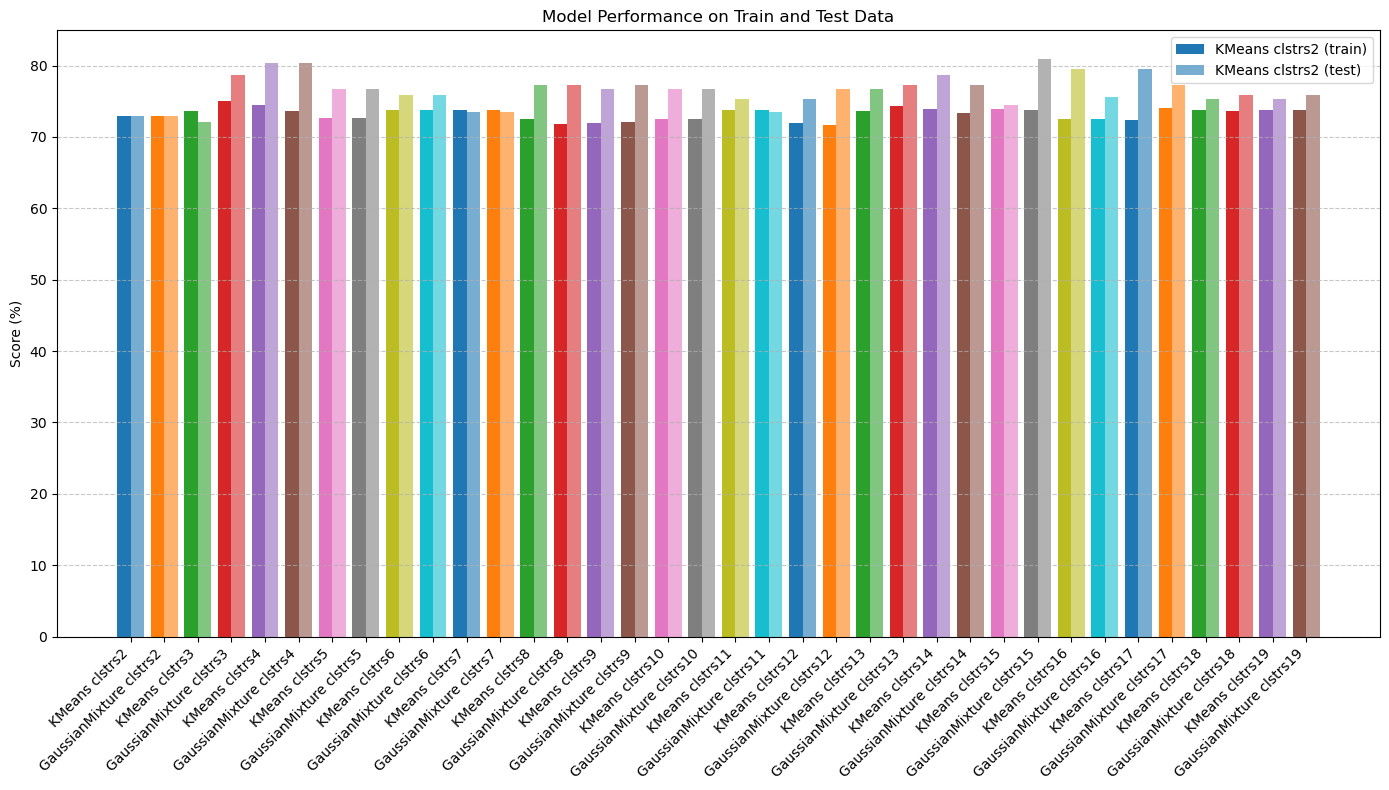

In [41]:
import matplotlib.pyplot as plt

models_and_components = list(results_train.keys())
train_scores = list(results_train.values())
test_scores = [results_test[model] for model in models_and_components]

# Extract model names and component values
x_labels = models_and_components
x_ticks = range(len(x_labels))

# Plot settings
bar_width = 0.4
colors = plt.cm.tab10.colors  # Use a colormap for consistent colors

# Create the bar plot
plt.figure(figsize=(14, 8))
for i, (train_score, test_score) in enumerate(zip(train_scores, test_scores)):
    color = colors[i % len(colors)]
    plt.bar(x_ticks[i] - bar_width / 2, train_score, bar_width, color=color, label=f"{x_labels[i]} (train)" if i == 0 else "")
    plt.bar(x_ticks[i] + bar_width / 2, test_score, bar_width, color=color, alpha=0.6, label=f"{x_labels[i]} (test)" if i == 0 else "")

# Customize plot
plt.xticks(ticks=x_ticks, labels=x_labels, rotation=45, ha="right")
plt.ylabel("Score (%)")
plt.title("Model Performance on Train and Test Data")
plt.legend(loc="best")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()